# Autoscout24.ch Price Monitor

The idea is to get an automated (eventually daily) price overview for a specific type of car. But also exploratory data analysis done to find some patterns or the 'best' valued car for money. 
As Autoscout24.ch does not offer a free API, we use web scraping to get the data we are interested in. 
Weak point in this approach is the possibility of changes in the HTML structure. This would require changes also in the Jupyter notebook. But this lies in the nature of web scraping.

(c) Manuel Kohler, Basel, Switzerland

In [1]:
import sys
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import seaborn as sns

# !{sys.executable} -m pip install numpy
# !pip install --upgrade pip --user

print(sys.version)

3.7.0 (v3.7.0:1bf9cc5093, Jun 26 2018, 23:26:24) 
[Clang 6.0 (clang-600.0.57)]


In [2]:


baseurl = 'https://www.autoscout24.ch'
bmwi3_baseurl = baseurl + '/de/autos/bmw--i3'
# default is 20 cars per page, which would mean 20*10 cars
maxpages = 10

link_list = [] 

for i in range(1, maxpages):
    # fuel:16 = electro only, no REX
    # make:9 = BMW
    # model:1949 = i3    
    payload = {'fuel':16, 'make': '9', 'model': '1949', 'page': i, 'st': 1, 'vehtyp': 10, 'sort': 'price_asc'}
    
    # Cayman S
#     payload = {'make': '62', 'model': '449', 'page': i, 'st': 1, 'vehtyp': 10, 'sort': 'price_asc'}    
    
    # Tesla S
#     payload = {'fuel':16, 'make': '391', 'model': '1919', 'page': i, 'st': 1, 'vehtyp': 10, 'sort': 'price_asc'}

    # VW e-Golf
#     payload = {'fuel':16, 'make': '82', 'model': '585', 'page': i, 'st': 1, 'vehtyp': 10, 'sort': 'price_asc'}

    # VW Petrol Golf
#     payload = {'fuel':14, 'make': '82', 'model': '585', 'page': i, 'st': 1, 'vehtyp': 10, 'sort': 'price_asc'}


    print('Loading page: ', i)    
    r = requests.get(bmwi3_baseurl, params=payload)
    soup = BeautifulSoup(r.text, 'html.parser')
#     print(soup.prettify(formatter=None))
    car_links = soup.find_all("a", class_="primary-link")

    # if no more new cars found we can exit the for loop. 
    # maxpages is then bigger than the real number of cars
    if (len(car_links) == 0):
        print(f"No more cars found after {i-1} iterations")
        break
    for car_link in car_links:
        link_list.append(car_link)
        
print('Found ' + str(len(link_list)) + ' cars')

Loading page:  1
Loading page:  2
Loading page:  3
Loading page:  4
Loading page:  5
Loading page:  6
Loading page:  7
No more cars found after 6 iterations
Found 106 cars


In [3]:
# data = {}
car_list = []

data_fields = ["Inverkehrsetzung", "Fahrzeugart", "Aussenfarbe", "Kilometer", "Getriebeart", 
               "Antriebsart", "Treibstoff", "Türen", "Sitze", "Innenfarbe", "Hubraum",
               "Zylinder", "PS", "Leergewicht", "Verbrauch in l/100 km","CO2-Emission",
               "Energieeffizienz", "Euro Norm", "Wagen-Nr.", "Ab MFK ", "Direkt-/Parallelimport",
               "Garantie", "Neupreis", "Preis"]

for carIdx, carVal in enumerate(link_list):
    car = {}
        
    if (carIdx % 10 == 0) and (carIdx > 0):
        print(f"Downloaded {carIdx} cars")
    individual_car_request = requests.get(baseurl + carVal.get('href'))
    soup = BeautifulSoup(individual_car_request.text, 'html.parser')
    
    # extract the individual vehical id given by autoscout, we assume that those are unique
    vehid = carVal.get('href').split("&")[7].split("=")[1]
    title = carVal.get('title')
    
    car['vehid'] = vehid
    car['carLink'] = baseurl + '/' + vehid
    car['title'] = title
    
    car_textlist_item = soup.find_all("li", class_="textlist-item")

    prop = soup.find_all("div", class_="prop")
    value = soup.find_all("div", class_="value")
      
    # I assume that a property has always a matching value!
    for idx, val in enumerate(prop):
#         print(val.get_text().strip())
        car[val.get_text().strip()] = value[idx].get_text().strip()
#         property_list.append(val.get_text().strip())
#         value_list.append(value[idx].get_text().strip())
#         data[vehid] = value_list[0:17]
        
    car_list.append(car)

print(f"Downloaded {carIdx+1} car details in total.")
#     print(len(value_list))

# print(car_list)

car_df = pd.DataFrame(car_list, dtype=object).fillna('0')

# print(property_list)
# print(data)
#     print(car['Preis'])    

Downloaded 10 cars
Downloaded 20 cars
Downloaded 30 cars
Downloaded 40 cars
Downloaded 50 cars
Downloaded 60 cars
Downloaded 70 cars
Downloaded 80 cars
Downloaded 90 cars
Downloaded 100 cars
Downloaded 106 car details in total.


In [4]:
pd.set_option('display.max_columns', 400)
# pd.set_option('display.max_colwidth', 10)


# interesting_df = car_df[['vehid', 'title', 'Inverkehrsetzung','Kilometer', 'Preis', 'Neupreis', 'carLink']]
interesting_df = car_df[['vehid', 'title', 'Inverkehrsetzung','Kilometer', 'Preis', 'carLink']]


abc = interesting_df.copy()

# Thanks for this hint:
# https://stackoverflow.com/questions/42263946/how-to-create-a-table-with-clickable-hyperlink-in-pandas-jupyter-notebook
def make_clickable(val):
    # target _blank to open new window
    return '<a target="_blank" href="{}">Link</a>'.format(val)

interesting_df.style.format({'carLink': make_clickable})

interesting_df.Preis


def only_numbers(Preis):
    latestPreis = Preis.split('\n')[0]
    p = re.compile('[^\d]+')
    return int(p.sub('', latestPreis))


abc['cleanPrice'] = abc.Preis.apply(only_numbers)
abc['cleanKilometer'] = abc.Kilometer.apply(only_numbers)

new_df = abc[['vehid', 'title', 'cleanKilometer', 'cleanPrice']]


In [5]:

# Missing on the webpage, sort by the latest uploaded cars
# I assume that the vehid is similar to a DB sequence
interesting_df.sort_values(by=['vehid'], ascending=False).style.format({'carLink': make_clickable})

,vehid,title,Inverkehrsetzung,Kilometer,Preis,carLink
88,6450030,BMW i3s (120Ah),Neu,100 km,CHF 48'600.-,Link
93,6444619,BMW i3 (120Ah),02.2019,3'000 km,CHF 50'955.-,Link
66,6443735,BMW i3 94 Ah,Neu,200 km,CHF 39'900.-,Link
33,6443193,"BMW i3 (94Ah), Facelift!",06.2018,8'900 km,CHF 31'490.-,Link
97,6441961,BMW i3s (120Ah),03.2019,3'500 km,CHF 52'580.-,Link
26,6437669,BMW i3 (94Ah),02.2018,100 km,CHF 29'900.-,Link
3,6431613,BMW i3 (60Ah),01.2015,34'000 km,CHF 19'800.-,Link
94,6431577,BMW i3 (120Ah),Neu,10 km,CHF 51'600.-,Link
90,6431504,BMW i3 (120Ah),Neu,10 km,CHF 49'850.-,Link
99,6430607,BMW i3s (120Ah),02.2019,2'000 km,CHF 52'999.-,Link


In [19]:
# might be better to subgroup them

cars_120Ah = interesting_df[interesting_df['title'].str.contains("120Ah")]
cars_94Ah = interesting_df[interesting_df['title'].str.contains("94Ah")]
cars_60Ah = interesting_df[interesting_df['title'].str.contains("60Ah")]

cars_120Ah

,vehid,title,Inverkehrsetzung,Kilometer,Preis,carLink
79,6424264,BMW i3s (120Ah),02.2019,100 km,CHF 44'900.-,https://www.autoscout24.ch/6424264
88,6450030,BMW i3s (120Ah),Neu,100 km,CHF 48'600.-,https://www.autoscout24.ch/6450030
89,6417815,BMW i3 (120Ah),Neu,100 km,CHF 49'700.-,https://www.autoscout24.ch/6417815
90,6431504,BMW i3 (120Ah),Neu,10 km,CHF 49'850.-,https://www.autoscout24.ch/6431504
91,6330172,BMW i3s (120Ah),01.2019,1'000 km,CHF 49'900.-,https://www.autoscout24.ch/6330172
93,6444619,BMW i3 (120Ah),02.2019,3'000 km,CHF 50'955.-,https://www.autoscout24.ch/6444619
94,6431577,BMW i3 (120Ah),Neu,10 km,CHF 51'600.-,https://www.autoscout24.ch/6431577
95,6207058,BMW i3s (120Ah),02.2019,250 km,CHF 51'600.-\n\n\r\n CHF 55'140...,https://www.autoscout24.ch/6207058
96,6414181,BMW i3s (120Ah),Neu,1 km,CHF 51'900.-,https://www.autoscout24.ch/6414181
97,6441961,BMW i3s (120Ah),03.2019,3'500 km,CHF 52'580.-,https://www.autoscout24.ch/6441961


In [6]:
import datetime
now = datetime.datetime.now()
interesting_df.to_csv(f"./cars_{payload['make']}_{payload['model']}_{now}.csv", encoding='utf-8')
interesting_df.to_excel(f"./cars_{payload['make']}_{payload['model']}_{now}.xlsx", sheet_name='Autoscout')

In [7]:
# Is not helpful currently
# interesting_df.describe()

In [8]:
# import matplotlib.pyplot as plt
# new_df.plot(kind='scatter',x='cleanPrice',y='cleanKilometer',color='red')
# plt.show()

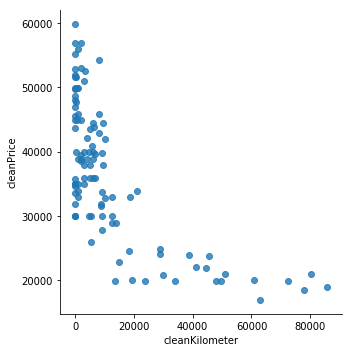

In [9]:
sns.lmplot('cleanKilometer', 'cleanPrice', data=new_df, fit_reg=False)

In [10]:
import numpy as np

# Let's try a naive way of finding the car with the best value (obvislously a soft target)
# which in this simple approach means all the dots which have a short distance to the origin. No features
# are considered in this case.
# We can easily calculate this using good old Pythagoras

a = new_df.copy()
a['dist_to_origin'] = np.sqrt((new_df['cleanKilometer'])^2 + (new_df['cleanPrice'])^2)
a.sort_values(by=['dist_to_origin'])

,vehid,title,cleanKilometer,cleanPrice,dist_to_origin
9,6076529,BMW i3 (60Ah),19450,19990,38.781439
7,6322582,BMW i3 (60Ah),23900,19900,65.726707
21,6124637,BMW i3 (60Ah),29000,24800,67.230945
20,6406003,BMW i3 (60Ah),18250,24500,79.987499
11,6212617,BMW i3 (60Ah),30000,20800,96.581572
19,6058137,BMW i3 (60Ah),28900,23997,107.745069
25,4787302,BMW i3 (94Ah),12500,28900,128.187363
29,6293337,BMW i3 (94Ah),12400,29900,132.649915
24,6247659,BMW i3 (94Ah),14000,28900,134.178985
23,6228465,BMW i3 (60Ah),9000,27800,142.828569
